In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import matplotlib.colors as colors

from nanonets.utils import fft, harmonic_strength, total_harmonic_distortion, sinusoidal_voltages
from scipy import signal
from scipy.spatial import ConvexHull, KDTree
from scipy.spatial.distance import pdist
from scipy.stats import gaussian_kde
from sklearn.decomposition import PCA

plt.style.use(["science","bright","grid"])
# PATH = "/home/j/j_mens07/bagheera/data/2_funding_period/dynamic/AC/freq_manipulation/"
PATH    = "/home/j/j_mens07/phd/data/2_funding_period/dynamic/AC/freq_manipulation/"
PATH_R  = "/home/j/j_mens07/phd/data/2_funding_period/dynamic/AC/res_disorder_freq_manipulation/"

## Paramter and Input Time Series

In [5]:
N_PARTICLES     = [3,9]
N_PERIODS       = 100
N_SAMPLES       = 1280
SAMPLE_P_PERIOD = 40
F0              = 28.0
F0_HZ           = F0 * 1e6
AMPLITUDE       = 0.02
U_BOUNDS        = 0.05
N_EQ_PERIODS    = 80
N_EQ_PERIODS_R  = 80
DT              = 1 / (SAMPLE_P_PERIOD * F0_HZ)
T_SIM           = N_PERIODS / F0_HZ
N_STEPS         = int(np.ceil(T_SIM / DT))

## Output Time Series and higher harmonics

In [284]:
def MC_effective_volume(points, M_samples, d_factor=0.5, bounds=0):
    
    # Define Distance
    pairwise_d  = pdist(points)
    d_radius    = d_factor * np.median(pairwise_d)

    if bounds == 0:
        min_bounds  = points.min(axis=0)
        max_bounds  = points.max(axis=0)
    else:
        min_bounds  = bounds[0]
        max_bounds  = bounds[1]

    # Define bounding box
    side_length = max_bounds - min_bounds
    v0_volume   = np.prod(side_length)

    # Generate Samples
    samples = np.random.rand(M_samples, points.shape[1])
    samples = samples * side_length + min_bounds

    # Neighbor search
    tree        = KDTree(points)
    d_to_nn, _  = tree.query(samples, k=1)
    hits        = np.sum(d_to_nn <= d_radius)

    # Effective Volume
    p_hit_rate  = hits / M_samples
    v_mc_eff    = p_hit_rate * v0_volume

    return v_mc_eff

def hh_amplitudes(y_val, n_vals, N_periods=20):
    N_samples   = len(y_val)
    window      = np.blackman(N_samples)
    y_windowed  = y_val * window
    w_gain      = np.sum(window) / N_samples
    fft_vals    = np.fft.rfft(y_windowed)
    amps        = []
    for m in n_vals:
        k = m * N_periods
        if k < len(fft_vals):
            Z_k = fft_vals[k]
            mag = (np.real(Z_k) * 2 / N_samples) / w_gain
            amps.append(mag)
        else:
            amps.append(0.0)
    return np.array(amps)

In [7]:
R_VALUES    = [50.0,100.0,200.0,400.0,800.0,1600.0]
N_SAMPLES_R = 600
data_R_15   = {R : {i : pd.read_csv(f"{PATH_R}Nx=9_Ny=9_Ne=8_{i}_mean2_{R}_15.csv").iloc[N_EQ_PERIODS*SAMPLE_P_PERIOD:].reset_index(drop=True)['Observable'].values*1e-6 for i in range(N_SAMPLES_R)} for R in R_VALUES}
data_R_10   = {R : {i : pd.read_csv(f"{PATH_R}Nx=9_Ny=9_Ne=8_{i}_mean2_{R}_10.csv").iloc[N_EQ_PERIODS*SAMPLE_P_PERIOD:].reset_index(drop=True)['Observable'].values*1e-6 for i in range(N_SAMPLES_R)} for R in R_VALUES}
data_R_19   = {R : {i : pd.read_csv(f"{PATH_R}Nx=9_Ny=9_Ne=8_{i}_mean2_{R}_19.csv").iloc[N_EQ_PERIODS*SAMPLE_P_PERIOD:].reset_index(drop=True)['Observable'].values*1e-6 for i in range(N_SAMPLES_R)} for R in R_VALUES}

In [261]:
N_SAMPLES   = 600
data_3      = {i : pd.read_csv(f"{PATH}Nx=3_Ny=3_Ne=8_{i}.csv") for i in range(N_SAMPLES)}
data_9      = {i : pd.read_csv(f"{PATH}Nx=9_Ny=9_Ne=8_{i}.csv") for i in range(N_SAMPLES)}
data_new_3  = [data_3[i].iloc[N_EQ_PERIODS*SAMPLE_P_PERIOD:].reset_index(drop=True)['Observable'].values*1e-6 for i in range(N_SAMPLES)]
data_new_9  = [data_9[i].iloc[N_EQ_PERIODS*SAMPLE_P_PERIOD:].reset_index(drop=True)['Observable'].values*1e-6 for i in range(N_SAMPLES)]

In [285]:
dim             = 2
n_vals          = np.arange(1,dim+1,1)
hh_vector_3     = np.array([hh_amplitudes(data_new_3[i], n_vals) for i in range(N_SAMPLES)])
hh_vector_9     = np.array([hh_amplitudes(data_new_9[i], n_vals) for i in range(N_SAMPLES)])

### Convex Hull

45.90216780360559
93.94471801328905


Text(0.5, 0, '$A_1$')

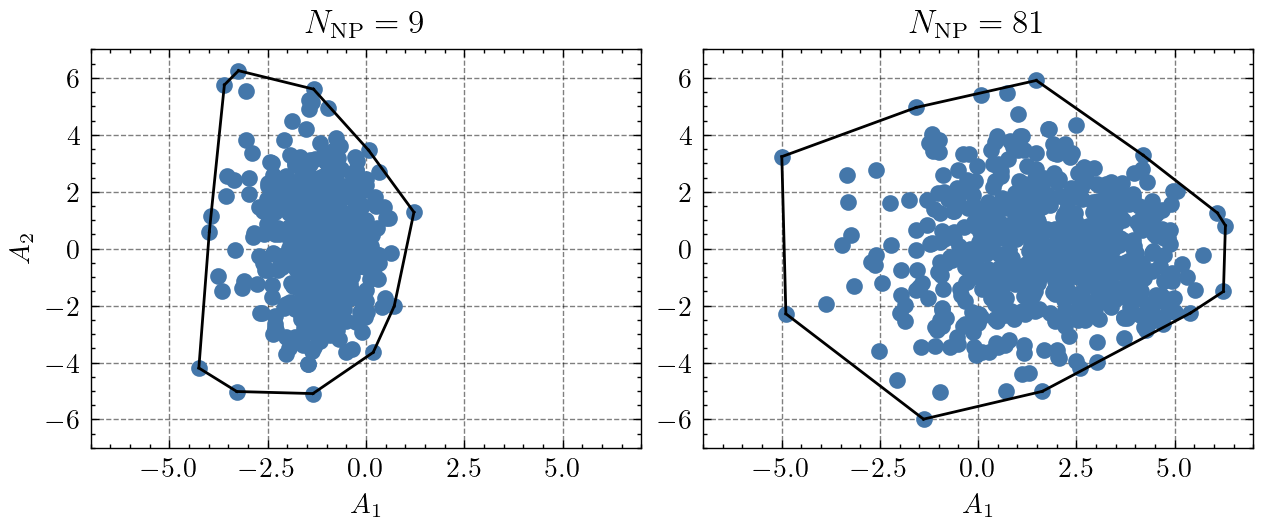

In [290]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.8)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

hull    = ConvexHull(hh_vector_3)
V_hull  = hull.volume
print(V_hull)
ax1.plot(hh_vector_3[:,0], hh_vector_3[:,1], 'o', ms=5)
for simplex in hull.simplices:
    ax1.plot(hh_vector_3[simplex, 0], hh_vector_3[simplex, 1], 'k-')
ax1.set_xlim(-7,7)
ax1.set_ylim(-7,7)
# ax1.set_xlim(0,50)
ax1.set_title("$N_\\textrm{NP} = 9$")
ax1.set_xlabel("$A_1$")
ax1.set_ylabel("$A_2$")

hull    = ConvexHull(hh_vector_9)
V_hull  = hull.volume
print(V_hull)
ax2.plot(hh_vector_9[:,0], hh_vector_9[:,1], 'o', ms=5)
for simplex in hull.simplices:
    ax2.plot(hh_vector_9[simplex, 0], hh_vector_9[simplex, 1], 'k-')
ax2.set_xlim(-7,7)
ax2.set_ylim(-7,7)
ax2.set_title("$N_\\textrm{NP} = 81$")
ax2.set_xlabel("$A_1$")

### Effective Volume
- 19 : MIN THD
- 15 : MAX THD / MIN Beta
- 10 : MIN TAU

### System Size Scaling

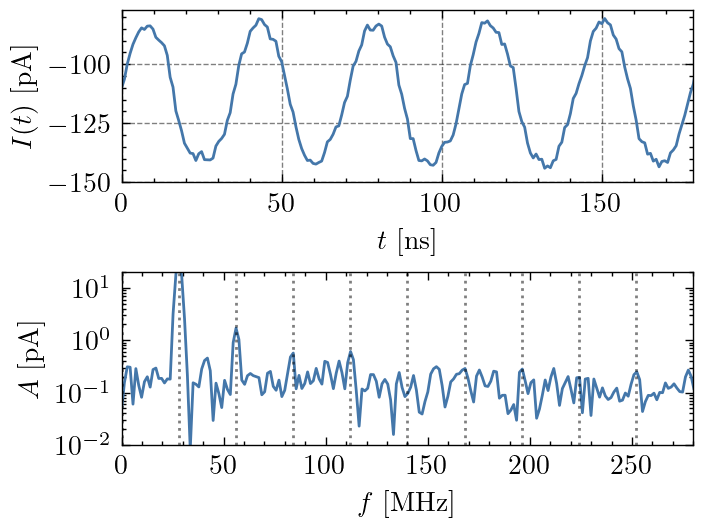

In [357]:
def get_frequency_spectrum(signal, dt):
    """
    Computes the calibrated one-sided amplitude spectrum.
    
    Parameters:
    - signal: 1D numpy array (time domain)
    - dt: Time step in seconds
    
    Returns:
    - freqs: Array of frequencies [Hz]
    - amplitudes: Array of physical amplitudes [A] (or whatever unit signal is in)
    """
    N_samples = len(signal)
    
    # 1. Apply Window (Consistent with your previous analysis)
    window = np.blackman(N_samples)
    y_val = signal - np.mean(signal)
    y_windowed = y_val * window
    
    # Window Coherent Gain Correction
    w_gain = np.sum(window) / N_samples
    
    # 2. Compute FFT
    fft_vals = np.fft.rfft(y_windowed)
    freqs = np.fft.rfftfreq(N_samples, dt)
    
    # 3. Normalize Magnitude
    # Scale for one-sided (*2), normalize by N, correct for window loss
    amplitudes = (np.abs(fft_vals) * 2 / N_samples) / w_gain
    
    return freqs, amplitudes

fig     = plt.figure(dpi=200, layout='constrained')
y_val   = data_new_9[20].copy()
t_val   = np.arange(len(y_val))*DT
ax      = fig.add_subplot(2,1,1)
_       = ax.plot(t_val*1e9, y_val)
_       = ax.set_xlim(0,t_val[SAMPLE_P_PERIOD*5]*1e9)
_       = ax.set_xlabel("$t$ [ns]")
_       = ax.set_ylabel("$I(t)$ [pA]")
ax      = fig.add_subplot(2,1,2)
xf, yf  = get_frequency_spectrum(y_val, DT)
_       = ax.semilogy(xf*1e-6, yf)
_       = ax.set_ylabel('$A$ [pA]')
_       = ax.set_xlim(0,10*F0)
_       = ax.set_ylim(0.01,20)
_       = ax.grid(False)
_       = ax.set_xlabel("$f$ [MHz]")
for n in range(10):
    plt.axvline(n*F0, color='black', ls=':', alpha=0.5)

In [358]:
def MC_effective_volume_fixed(points, M_samples, fixed_radius, global_bounds):
    """
    Calculates effective volume using fixed global constraints.
    """
    min_bounds, max_bounds = global_bounds
    side_length = max_bounds - min_bounds
    v0_volume   = np.prod(side_length)

    # Generate Samples within the Global Box
    samples = np.random.rand(M_samples, points.shape[1])
    samples = samples * side_length + min_bounds

    # Neighbor search
    tree        = KDTree(points)
    # Check if samples are close to ANY point in the set
    d_to_nn, _  = tree.query(samples, k=1)
    hits        = np.sum(d_to_nn <= fixed_radius)

    # Effective Volume
    p_hit_rate  = hits / M_samples
    v_mc_eff    = p_hit_rate * v0_volume

    return v_mc_eff

In [402]:
M_SAMPLES   = 100000
d_factors   = np.logspace(-2,1,31)
dim_vals    = np.arange(1,7)
V_eff_3_dic = {}
V_eff_9_dic = {}
for dim in dim_vals:
    n_vals      = np.arange(1,dim+1,1)
    hh_vector_3 = np.array([hh_amplitudes(data_new_3[i], n_vals) for i in range(N_SAMPLES)])
    hh_vector_9 = np.array([hh_amplitudes(data_new_9[i], n_vals) for i in range(N_SAMPLES)])
    all_data    = np.vstack([hh_vector_3,hh_vector_9])
    min_b       = all_data.min(axis=0)
    max_b       = all_data.max(axis=0)
    margin      = (max_b - min_b) * 0.05
    global_b    = (min_b - margin, max_b + margin)
    # pw_d_base   = pdist(hh_vector_3)
    pw_d_base   = pdist(all_data)
    V_eff_3     = []
    V_eff_9     = []
    for d_factor in d_factors:
        fixed_rad   = d_factor * np.median(pw_d_base)
        V_eff_3.append(MC_effective_volume_fixed(hh_vector_3, M_SAMPLES, fixed_rad, global_b))
        V_eff_9.append(MC_effective_volume_fixed(hh_vector_9, M_SAMPLES, fixed_rad, global_b))
    V_eff_3_dic[dim] = V_eff_3
    V_eff_9_dic[dim] = V_eff_9

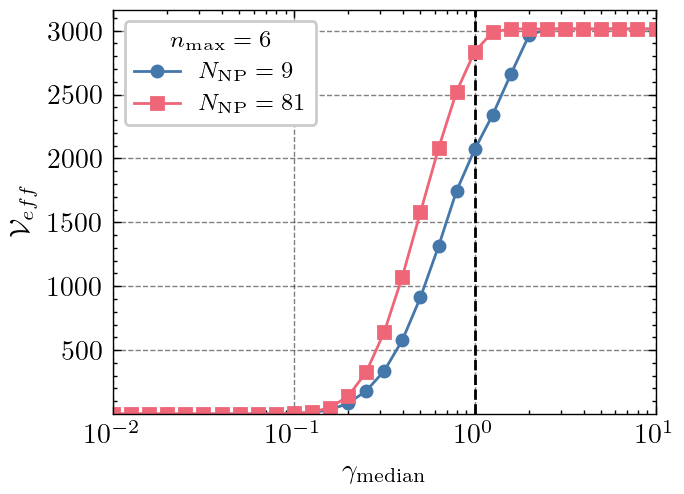

In [408]:
dim     = 6
d_idx   = 20
fig, ax = plt.subplots(dpi=200)
_       = ax.plot(d_factors, V_eff_3_dic[dim], label="$N_\\textrm{NP} = 9$", marker='o', ms=4)
_       = ax.plot(d_factors, V_eff_9_dic[dim], label="$N_\\textrm{NP} = 81$", marker='s', ms=4)
_       = plt.axvline(d_factors[d_idx], color='black', ls='--', zorder=0.1)
_       = ax.set_xlim(d_factors[0], d_factors[-1])
_       = ax.set_xlabel("$\gamma_\\textrm{median}$")
_       = ax.set_xscale('log')
_       = ax.set_ylabel("$\mathcal{V}_{eff}$")
_       = ax.legend(fontsize='small', title='$n_\\textrm{max} ='+f' {dim}$', title_fontsize='small')
_       = ax.set_ylim(5e-2)

fig.savefig("plots/png/V_eff_vs_gamma_median_system_size.png", transparent=False)
fig.savefig("plots/pdf/V_eff_vs_gamma_median_system_size.pdf", transparent=False)
fig.savefig("plots/svg/V_eff_vs_gamma_median_system_size.svg", transparent=True)

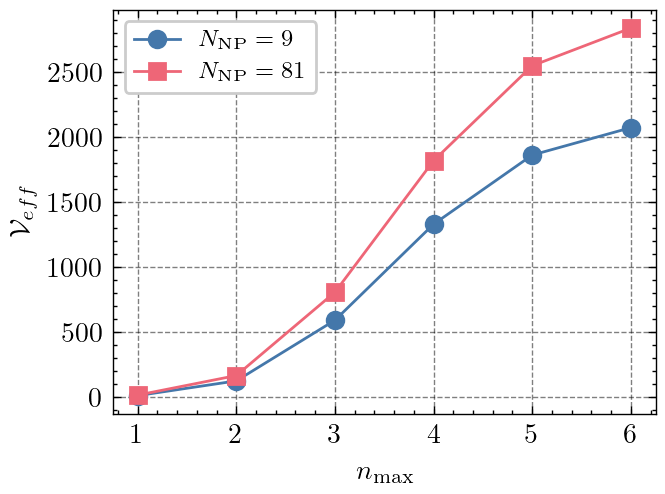

In [404]:
fig, ax = plt.subplots(dpi=200)
_       = ax.plot(dim_vals, [V_eff_3_dic[d][d_idx] for d in dim_vals], label="$N_\\textrm{NP} = 9$", marker='o')
_       = ax.plot(dim_vals, [V_eff_9_dic[d][d_idx] for d in dim_vals], label="$N_\\textrm{NP} = 81$", marker='s')
_       = ax.set_xticks(dim_vals)
_       = ax.set_xlabel("$n_\\textrm{max}$")
_       = ax.set_ylabel("$\mathcal{V}_{eff}$")
_       = ax.legend(fontsize='small')

fig.savefig("plots/png/V_eff_vs_n_max_system_size.png", transparent=False)
fig.savefig("plots/pdf/V_eff_vs_n_max_system_size.pdf", transparent=False)
fig.savefig("plots/svg/V_eff_vs_n_max_system_size.svg", transparent=True)

### Disorder

In [ ]:
M_SAMPLES           = 100
d_factors           = np.logspace(-2,1,31)
dim_vals            = np.arange(1,7)
V_eff_9_dic         = {}
V_eff_min_THD_dic   = {}
V_eff_max_THD_dic   = {}
for dim in dim_vals:
    n_vals          = np.arange(1,dim+1,1)
    hh_vector_9     = np.array([hh_amplitudes(data_new_9[i], n_vals) for i in range(N_SAMPLES)])
    hh_vector_R_19  = {R : np.array([hh_amplitudes(data_R_19[R][i], n_vals) for i in range(N_SAMPLES_R)]) for R in R_VALUES}
    hh_vector_R_15  = {R : np.array([hh_amplitudes(data_R_15[R][i], n_vals) for i in range(N_SAMPLES_R)]) for R in R_VALUES}
    all_data        = hh_vector_9.copy()
    for R in R_VALUES:
        all_data = np.vstack([all_data, hh_vector_R_19[R]])
        all_data = np.vstack([all_data, hh_vector_R_15[R]])
    min_b       = all_data.min(axis=0)
    max_b       = all_data.max(axis=0)
    margin      = (max_b - min_b) * 0.05
    global_b    = (min_b - margin, max_b + margin)
    # pw_d_base   = pdist(hh_vector_9)
    pw_d_base   = pdist(all_data)
    V_eff_9     = []
    for d_factor in d_factors:
        fixed_rad   = d_factor * np.median(pw_d_base)
        V_eff_9.append(MC_effective_volume_fixed(hh_vector_9, M_SAMPLES, fixed_rad, global_b))
    V_eff_9_dic[dim] = V_eff_9
    V_eff_min_THD    = {}
    V_eff_max_THD    = {}
    for R in R_VALUES:
        V_eff_min   = []
        V_eff_max   = []
        for d_factor in d_factors:
            fixed_rad = d_factor * np.median(pw_d_base)
            V_eff_min.append(MC_effective_volume_fixed(hh_vector_R_19[R], M_SAMPLES, fixed_rad, global_b))
            V_eff_max.append(MC_effective_volume_fixed(hh_vector_R_15[R], M_SAMPLES, fixed_rad, global_b))
        V_eff_min_THD[R] = V_eff_min
        V_eff_max_THD[R] = V_eff_max
    V_eff_min_THD_dic[dim] = V_eff_min_THD
    V_eff_max_THD_dic[dim] = V_eff_max_THD

In [ ]:
dim     = 5
d_idx   = 20
fig, ax = plt.subplots(dpi=200)
_       = ax.plot(d_factors, V_eff_9_dic[dim], label="$R_2 = 25~\mathrm{M\Omega}$", marker='s', ms=4)
for R in R_VALUES:
    _   = ax.plot(d_factors, V_eff_min_THD_dic[dim][R], label=f"$R_2 = {R}"+"~\mathrm{M\Omega}$", marker='s', ms=4)
# _       = plt.axvline(d_factors[d_idx], color='black', ls='--', zorder=0.1)
_       = ax.set_xlim(d_factors[0], d_factors[-1])
_       = ax.set_xlabel("$\gamma_\\textrm{median}$")
_       = ax.set_xscale('log')
_       = ax.set_ylabel("$\mathcal{V}_{eff}$")
_       = ax.legend(fontsize='small')
_       = ax.set_ylim(5e-2)

# fig.savefig("plots/png/V_eff_vs_gamma_median_system_size.png", transparent=False)
# fig.savefig("plots/pdf/V_eff_vs_gamma_median_system_size.pdf", transparent=False)
# fig.savefig("plots/svg/V_eff_vs_gamma_median_system_size.svg", transparent=True)

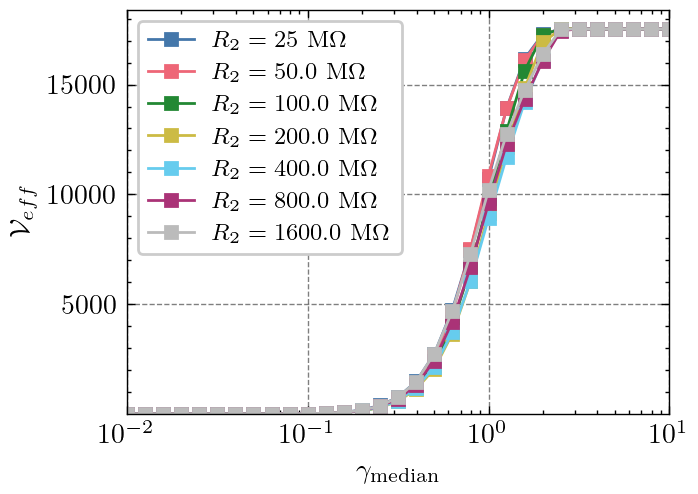

In [ ]:
dim     = 5
d_idx   = 20
fig, ax = plt.subplots(dpi=200)
_       = ax.plot(d_factors, V_eff_9_dic[dim], label="$R_2 = 25~\mathrm{M\Omega}$", marker='s', ms=4)
for R in R_VALUES:
    _   = ax.plot(d_factors, V_eff_max_THD_dic[dim][R], label=f"$R_2 = {R}"+"~\mathrm{M\Omega}$", marker='s', ms=4)
# _       = plt.axvline(d_factors[d_idx], color='black', ls='--', zorder=0.1)
_       = ax.set_xlim(d_factors[0], d_factors[-1])
_       = ax.set_xlabel("$\gamma_\\textrm{median}$")
_       = ax.set_xscale('log')
_       = ax.set_ylabel("$\mathcal{V}_{eff}$")
_       = ax.legend(fontsize='small')
_       = ax.set_ylim(5e-2)

# fig.savefig("plots/png/V_eff_vs_gamma_median_system_size.png", transparent=False)
# fig.savefig("plots/pdf/V_eff_vs_gamma_median_system_size.pdf", transparent=False)
# fig.savefig("plots/svg/V_eff_vs_gamma_median_system_size.svg", transparent=True)

In [218]:
M_SAMPLES       = 100000
d_mc_vals       = np.logspace(-2,1,31)
dim_vals        = np.arange(1,11)
V_eff_3_dic     = {}
V_eff_9_dic     = {}
V_eff_R_15_dic  = {}
V_eff_R_10_dic  = {}
V_eff_R_19_dic  = {}
for dim in dim_vals:
    n_vals = np.arange(1,dim+1,1)

    # Higher Harmonics
    hh_vector_3     = np.array([hh_amplitudes(data_new_3[i], n_vals) for i in range(N_SAMPLES)])
    hh_vector_9     = np.array([hh_amplitudes(data_new_9[i], n_vals) for i in range(N_SAMPLES)])
    hh_vector_R_15  = {R : np.array([hh_amplitudes(data_R_15[R][i], n_vals) for i in range(N_SAMPLES_R)]) for R in R_VALUES}
    hh_vector_R_10  = {R : np.array([hh_amplitudes(data_R_10[R][i], n_vals) for i in range(N_SAMPLES_R)]) for R in R_VALUES}
    hh_vector_R_19  = {R : np.array([hh_amplitudes(data_R_19[R][i], n_vals) for i in range(N_SAMPLES_R)]) for R in R_VALUES}

    # Bounds
    bounds_3        = get_bounds(hh_vector_3)
    bounds_9        = get_bounds(hh_vector_9)
    bounds_R_15     = [get_bounds(hh_vector_R_15[R]) for R in R_VALUES]
    bounds_R_10     = [get_bounds(hh_vector_R_10[R]) for R in R_VALUES]
    bounds_R_19     = [get_bounds(hh_vector_R_19[R]) for R in R_VALUES]
    min_bounds_10   = np.min(np.array(bounds_R_10),axis=0)[0,:]
    max_bounds_10   = np.max(np.array(bounds_R_10),axis=0)[1,:]
    min_bounds_15   = np.min(np.array(bounds_R_15),axis=0)[0,:]
    max_bounds_15   = np.max(np.array(bounds_R_15),axis=0)[1,:]
    min_bounds_19   = np.min(np.array(bounds_R_19),axis=0)[0,:]
    max_bounds_19   = np.max(np.array(bounds_R_19),axis=0)[1,:]
    min_bounds      = np.vstack((bounds_3[0],bounds_9[0],min_bounds_10,min_bounds_15,min_bounds_19))
    max_bounds      = np.vstack((bounds_3[1],bounds_9[1],max_bounds_10,max_bounds_15,max_bounds_19))
    bounds          = [np.min(min_bounds,axis=0), np.max(max_bounds,axis=0)]
    bounds = 0

    # Effective Volume
    V_eff_3         = [MC_effective_volume(hh_vector_3, M_SAMPLES, d, bounds) for d in d_mc_vals] 
    V_eff_9         = [MC_effective_volume(hh_vector_9, M_SAMPLES, d, bounds) for d in d_mc_vals]
    V_eff_R_15      = {R : [MC_effective_volume(hh_vector_R_15[R], M_SAMPLES, d, bounds) for d in d_mc_vals] for R in R_VALUES}
    V_eff_R_10      = {R : [MC_effective_volume(hh_vector_R_10[R], M_SAMPLES, d, bounds) for d in d_mc_vals] for R in R_VALUES}
    V_eff_R_19      = {R : [MC_effective_volume(hh_vector_R_19[R], M_SAMPLES, d, bounds) for d in d_mc_vals] for R in R_VALUES} 
    V_eff_3_dic[dim]    = V_eff_3
    V_eff_9_dic[dim]    = V_eff_9
    V_eff_R_15_dic[dim] = V_eff_R_15
    V_eff_R_10_dic[dim] = V_eff_R_10
    V_eff_R_19_dic[dim] = V_eff_R_19

### System Size Scaling

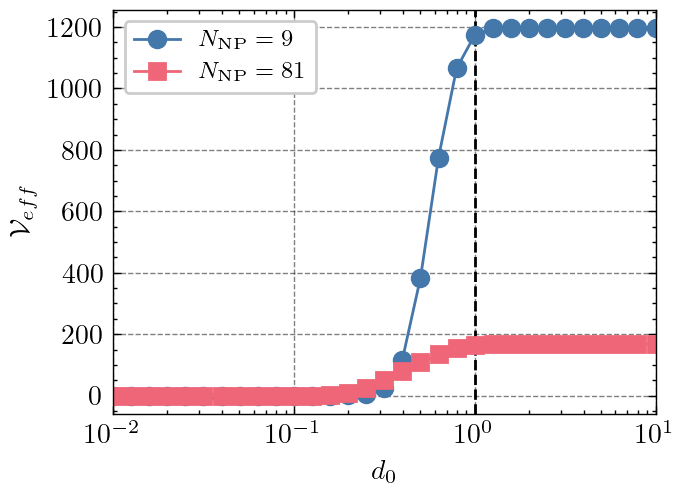

In [219]:
dim     = 10
d_idx   = 20
fig, ax = plt.subplots(dpi=200)
_       = ax.plot(d_mc_vals, V_eff_3_dic[dim], label="$N_\\textrm{NP} = 9$", marker='o')
_       = ax.plot(d_mc_vals, V_eff_9_dic[dim], label="$N_\\textrm{NP} = 81$", marker='s')
_       = plt.axvline(d_mc_vals[d_idx], color='black', ls='--', zorder=0.1)
_       = ax.set_xlim(d_mc_vals[0], d_mc_vals[-1])
_       = ax.set_xlabel("$d_0$")
_       = ax.set_xscale('log')
_       = ax.set_ylabel("$\mathcal{V}_{eff}$")
_       = ax.legend(fontsize='small')

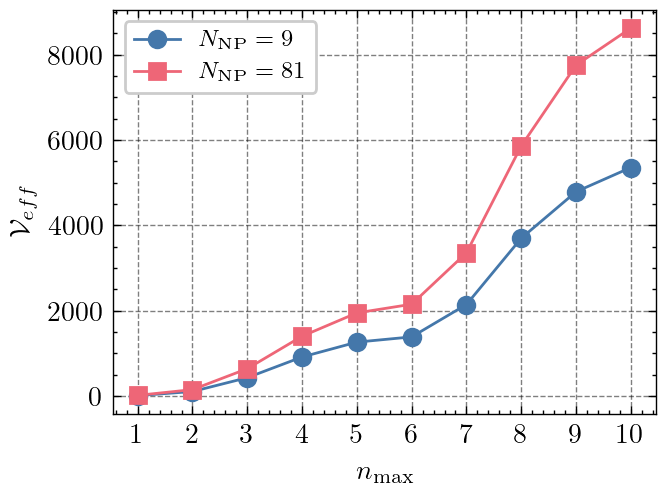

In [363]:
fig, ax = plt.subplots(dpi=200)
_       = ax.plot(dim_vals, [V_eff_3_dic[d][d_idx] for d in np.arange(1,11)], label="$N_\\textrm{NP} = 9$", marker='o')
_       = ax.plot(dim_vals, [V_eff_9_dic[d][d_idx] for d in np.arange(1,11)], label="$N_\\textrm{NP} = 81$", marker='s')
_       = ax.set_xticks(dim_vals)
_       = ax.set_xlabel("$n_\\textrm{max}$")
_       = ax.set_ylabel("$\mathcal{V}_{eff}$")
# _       = ax.set_xscale('log')
# _       = ax.set_yscale('log')
_       = ax.legend(fontsize='small')

### Disorder

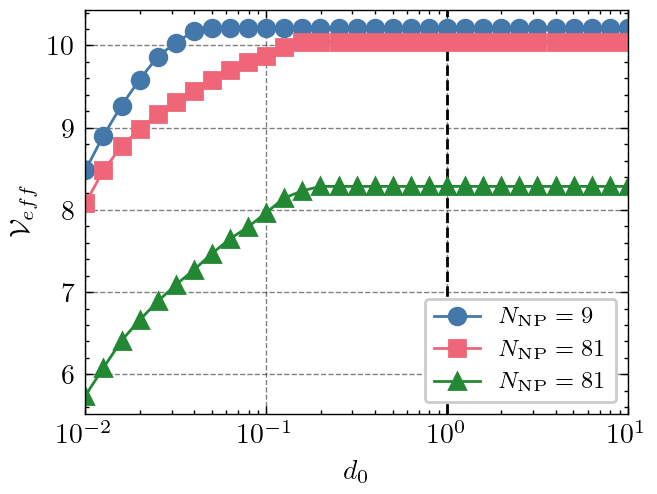

In [221]:
dim     = 1
d_idx   = 20
R_val   = 1600
fig, ax = plt.subplots(dpi=200)
_       = ax.plot(d_mc_vals, V_eff_R_10_dic[dim][R_val], label="$N_\\textrm{NP} = 9$", marker='o')
_       = ax.plot(d_mc_vals, V_eff_R_15_dic[dim][R_val], label="$N_\\textrm{NP} = 81$", marker='s')
_       = ax.plot(d_mc_vals, V_eff_R_19_dic[dim][R_val], label="$N_\\textrm{NP} = 81$", marker='^')
_       = plt.axvline(d_mc_vals[d_idx], color='black', ls='--', zorder=0.1)
_       = ax.set_xlim(d_mc_vals[0], d_mc_vals[-1])
_       = ax.set_xlabel("$d_0$")
_       = ax.set_xscale('log')
_       = ax.set_ylabel("$\mathcal{V}_{eff}$")
_       = ax.legend(fontsize='small')

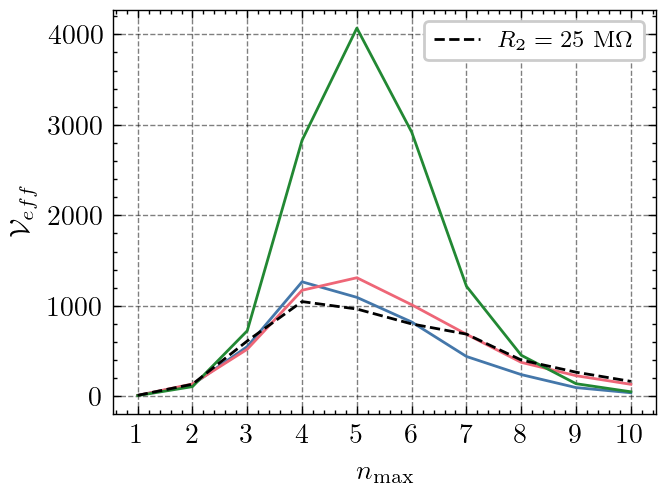

In [222]:
R       = 1600
fig, ax = plt.subplots(dpi=200)
_       = ax.plot(dim_vals, [V_eff_R_15_dic[d][R][d_idx] for d in dim_vals])
_       = ax.plot(dim_vals, [V_eff_R_10_dic[d][R][d_idx] for d in dim_vals])
_       = ax.plot(dim_vals, [V_eff_R_19_dic[d][R][d_idx] for d in dim_vals])
_       = ax.plot(dim_vals, [V_eff_9_dic[d][d_idx] for d in dim_vals], '--', label="$R_2 = 25~\\mathrm{M\Omega}$", color='black')
_       = ax.set_xticks(dim_vals)
_       = ax.set_xlabel("$n_\\textrm{max}$")
_       = ax.set_ylabel("$\mathcal{V}_{eff}$")
_       = ax.legend(fontsize='small')

In [203]:
pd.DataFrame([V_eff_3_dic[d][d_idx] for d in dim_vals])

,0
0,6.889062
1,109.425342
2,488.483024
3,1572.234182
4,2755.077276
5,2827.249531
6,3918.062825
7,6076.970108
8,7405.020186
9,7294.913069


In [206]:
V_eff_results   = pd.DataFrame()

df1_tmp         = pd.DataFrame([[V_eff_R_15_dic[d][R][d_idx] for d in dim_vals] for R in R_VALUES])
df1_tmp.columns = dim_vals
df1_tmp['R']    = R_VALUES
df1_tmp['Net']  = '15'
df1_tmp         = df1_tmp.melt(id_vars=['R','Net'], var_name='n', value_name='V')
V_eff_results   = pd.concat([V_eff_results,df1_tmp],ignore_index=True)

df1_tmp         = pd.DataFrame([[V_eff_R_10_dic[d][R][d_idx] for d in dim_vals] for R in R_VALUES])
df1_tmp.columns = dim_vals
df1_tmp['R']    = R_VALUES
df1_tmp['Net']  = '10'
df1_tmp         = df1_tmp.melt(id_vars=['R','Net'], var_name='n', value_name='V')
V_eff_results   = pd.concat([V_eff_results,df1_tmp],ignore_index=True)

df1_tmp         = pd.DataFrame([[V_eff_R_19_dic[d][R][d_idx] for d in dim_vals] for R in R_VALUES])
df1_tmp.columns = dim_vals
df1_tmp['R']    = R_VALUES
df1_tmp['Net']  = '19'
df1_tmp         = df1_tmp.melt(id_vars=['R','Net'], var_name='n', value_name='V')
V_eff_results   = pd.concat([V_eff_results,df1_tmp],ignore_index=True)

df1_tmp         = pd.DataFrame([V_eff_3_dic[d][d_idx] for d in dim_vals]).T
df1_tmp.columns = dim_vals
df1_tmp['R']    = 25
df1_tmp['Net']  = 9
df1_tmp         = df1_tmp.melt(id_vars=['R','Net'], var_name='n', value_name='V')
V_eff_results   = pd.concat([V_eff_results,df1_tmp],ignore_index=True)

/tmp/ipykernel_16376/3058872488.py:4: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax  = sns.violinplot(data=V_eff_results, x='n', y='V', hue='Net', fill=True, cut=0, inner='point', scale='width')


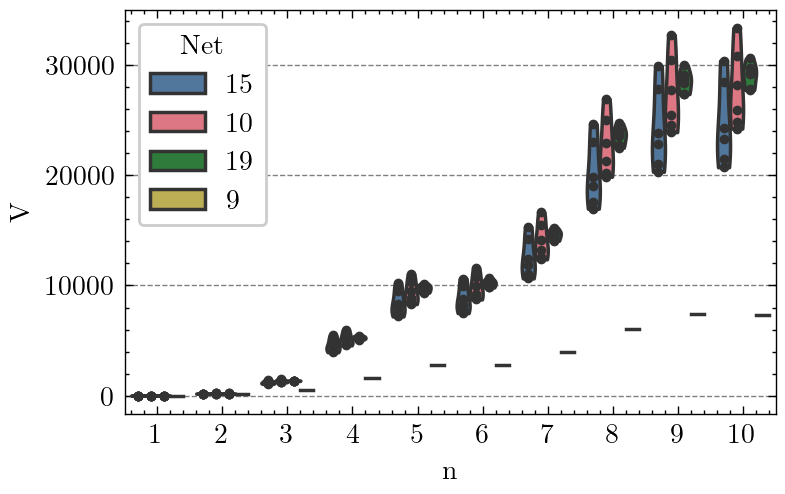

In [217]:
fig = plt.figure(dpi=200)
fig.set_figwidth(fig.get_figwidth()*1.2)
ax  = fig.add_subplot()
ax  = sns.violinplot(data=V_eff_results, x='n', y='V', hue='Net', fill=True, cut=0, inner='point', scale='width')

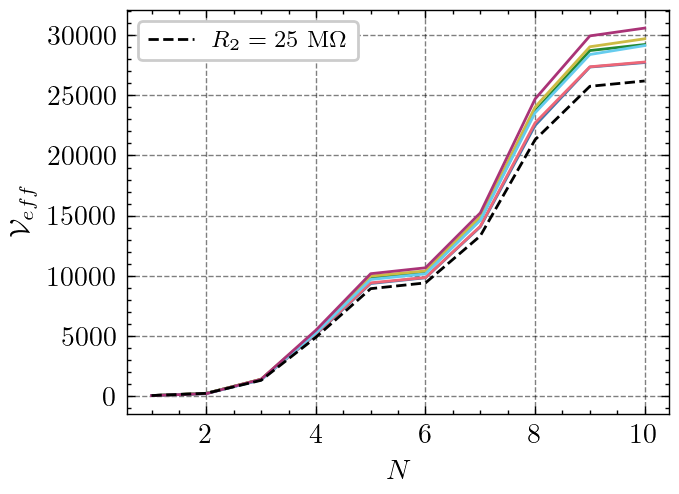

In [178]:
fig, ax = plt.subplots(dpi=200)
for R in R_VALUES:
    # ax.plot(np.arange(1,11), [V_eff_R_10_dic[d][R][10] for d in np.arange(1,11)])
    # ax.plot(np.arange(1,11), [V_eff_R_15_dic[d][R][10] for d in np.arange(1,11)])
    ax.plot(np.arange(1,11), [V_eff_R_19_dic[d][R][d_idx] for d in np.arange(1,11)])
ax.plot(np.arange(1,11), [V_eff_9_dic[d][d_idx] for d in np.arange(1,11)], '--', label="$R_2 = 25~\\mathrm{M\Omega}$", color='black')
_ = ax.set_xlabel("$N$")
_ = ax.set_ylabel("$\mathcal{V}_{eff}$")
_ = ax.legend(fontsize='small')

### Nonlinear Metrics

In [305]:
def compute_spectral_centroid(amplitudes, harmonic_orders, exclude_fundamental=True):
    """
    Calculates the Spectral Centroid (Center of Mass of the Harmonic Spectrum).
    
    Formula: C = Sum(n * A_n^2) / Sum(A_n^2)
    (Weighted by Power, consistent with energy distribution)
    
    Parameters:
    - amplitudes: Array of magnitudes [A_1, A_3, A_5...]
    - harmonic_orders: Array of harmonic indices [1, 3, 5...]
    - exclude_fundamental: If True, calculates the centroid of the DISTORTION only (n > 1).
                           If False, includes the fundamental frequency.
    
    Returns:
    - centroid: The weighted average harmonic order (e.g., 3.5 means energy is between n=3 and n=5).
    """
    # Ensure inputs are numpy arrays
    amps = np.asarray(amplitudes)
    ords = np.asarray(harmonic_orders)
    
    # 1. Filter: Decide whether to include n=1
    if exclude_fundamental:
        # Only keep harmonics where n > 1
        mask = ords > 1
        valid_amps = amps[mask]
        valid_ords = ords[mask]
    else:
        valid_amps = amps
        valid_ords = ords
        
    # 2. Calculate Power (Square of Amplitude)
    power = valid_amps**2
    total_power = np.sum(power)
    
    # 3. Safety Check for Zero Distortion
    if total_power < 1e-20:
        return np.nan # No harmonic energy exists
        
    # 4. Calculate Centroid
    # Sum(n * Power) / Sum(Power)
    centroid = np.sum(valid_ords * power) / total_power
    
    return centroid

def compute_thd(amplitudes):
    """
    Calculates Total Harmonic Distortion (THD).
    Input: Array of amplitudes [A_fund, A_harm1, A_harm2, ...]
    """
    if len(amplitudes) < 2 or amplitudes[0] == 0:
        return 0.0
        
    power_fund = amplitudes[0]**2
    power_harm = np.sum(amplitudes[1:]**2)
    
    return np.sqrt(power_harm) / np.sqrt(power_fund)

In [306]:
def data_abundance(y):
    y   = np.asarray(y)
    x   = np.sort(y)
    p_x = 1. * np.arange(len(x)) / float(len(x) - 1)
    ab  = 100 - 100*p_x
    return x, ab

In [307]:
dim         = 5
n_vals      = np.arange(1,dim+1,1)
hh_vector_3 = np.array([hh_amplitudes(data_new_3[i], n_vals) for i in range(N_SAMPLES)])
hh_vector_9 = np.array([hh_amplitudes(data_new_9[i], n_vals) for i in range(N_SAMPLES)])
centr_3 = [compute_spectral_centroid(hh_vector_3[i], n_vals, True) for i in range(N_SAMPLES)]
centr_9 = [compute_spectral_centroid(hh_vector_9[i], n_vals, True) for i in range(N_SAMPLES)]
thds_3  = [compute_thd(hh_vector_3[i]) for i in range(N_SAMPLES)]
thds_9  = [compute_thd(hh_vector_9[i]) for i in range(N_SAMPLES)]

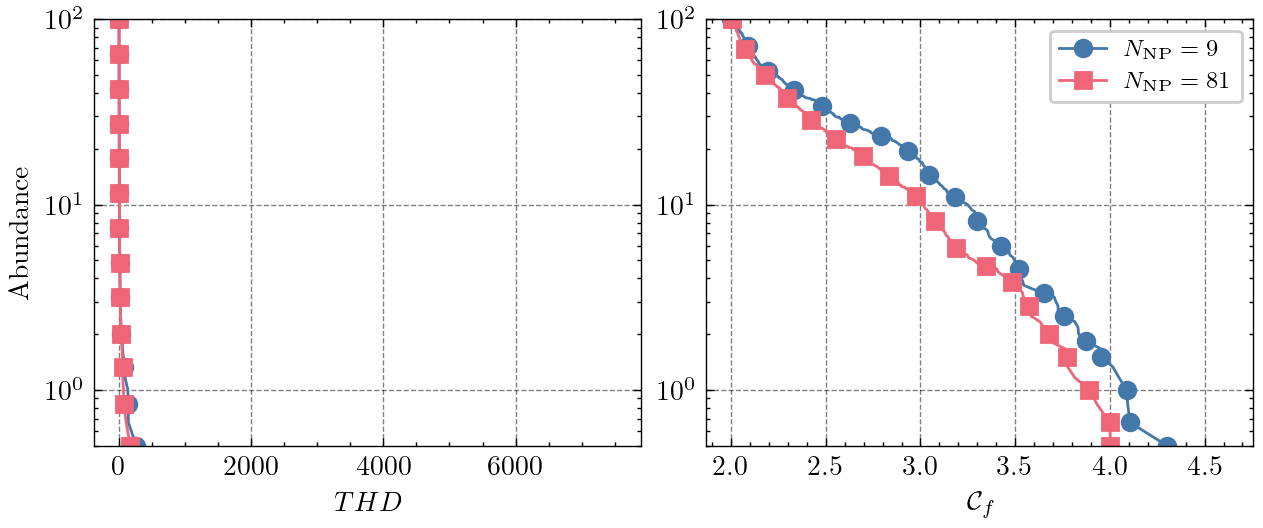

In [308]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.8)
ax      = fig.add_subplot(1,2,1)
x, ab   = data_abundance(thds_3)
_       = ax.plot(x, ab, label="$N_\\textrm{NP} = 9$", marker='o', markevery=0.05)
x, ab   = data_abundance(thds_9)
_       = ax.plot(x, ab, label="$N_\\textrm{NP} = 81$", marker='s', markevery=0.05)
_       = ax.set_xlabel('$THD$')
_       = ax.set_ylabel('Abundance')
_       = ax.set_ylim(0.5,100)
ax.set_yscale('log')

ax      = fig.add_subplot(1,2,2)
x, ab   = data_abundance(centr_3)
_       = ax.plot(x, ab, label="$N_\\textrm{NP} = 9$", marker='o', markevery=0.05)
x, ab   = data_abundance(centr_9)
_       = ax.plot(x, ab, label="$N_\\textrm{NP} = 81$", marker='s', markevery=0.05)
_       = ax.set_xlabel('$\mathcal{C}_f$')
_       = ax.set_ylim(0.5,100)
_       = ax.legend(fontsize='small')
ax.set_yscale('log')

---

In [189]:
def MC_effective_volume(points, M_samples, d_factor=0.5):
    
    # Define Distance
    pairwise_d  = pdist(points)
    d_radius    = d_factor * np.median(pairwise_d)

    # Define bounding box
    min_bounds  = points.min(axis=0)
    max_bounds  = points.max(axis=0)
    side_length = max_bounds - min_bounds
    v0_volume   = np.prod(side_length)

    # Generate Samples
    samples = np.random.rand(M_samples, points.shape[1])
    samples = samples * side_length + min_bounds

    # Neighbor search
    tree        = KDTree(points)
    d_to_nn, _  = tree.query(samples, k=1)
    hits        = np.sum(d_to_nn <= d_radius)

    # Effective Volume
    p_hit_rate  = hits / M_samples
    v_mc_eff    = p_hit_rate * v0_volume

    return v_mc_eff

M_samples   = [1e3,1e4,1e5,1e6]
d_mc_vals   = np.linspace(0.1,0.9,21)
V_mc_effs   = [[MC_effective_volume(hh_vector, int(M), d) for d in d_mc_vals] for M in M_samples]

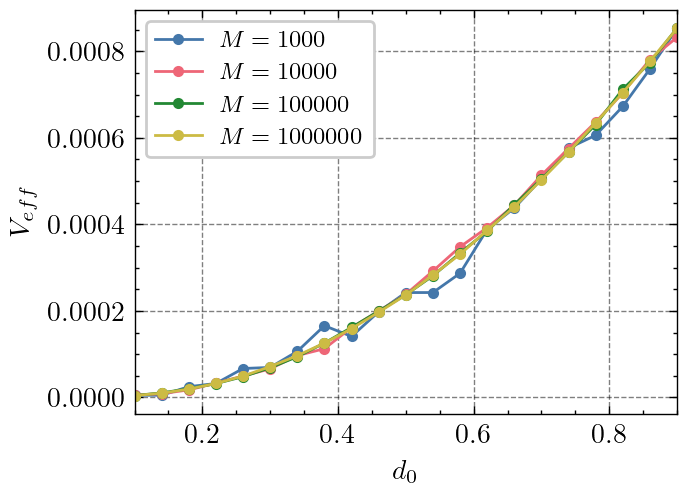

In [ ]:
fig, ax = plt.subplots(dpi=200)
# ax.hlines(V_hull, d_vals[0], d_vals[-1], color='black', ls='--', label='$V_{hull}$')
for i, M in enumerate(M_samples):
    ax.plot(d_mc_vals, V_mc_effs[i], '.-', label=f'$M = {int(M)}$')
ax.set_xlim(d_mc_vals[0], d_mc_vals[-1])
ax.set_xlabel("$d_0$")
ax.set_ylabel("$V_{eff,MC}$")
# ax.set_ylim(1e-3)
# ax.set_yscale('log')
ax.legend(fontsize='small')

In [192]:
def KDE_effective_volume(points, M_samples, density_percentile=0.05):
    
    # Fit KDE and get Desity
    kde                 = gaussian_kde(points.T, bw_method='scott')
    densities_at_points = kde(points.T)
    density_threshold   = np.quantile(densities_at_points, density_percentile)

    # Define bounding box
    min_bounds  = points.min(axis=0) #- 3 * points.std(axis=0)
    max_bounds  = points.max(axis=0) #+ 3 * points.std(axis=0)
    side_length = max_bounds - min_bounds
    v0_volume   = np.prod(side_length)

    # Generate Samples
    samples = np.random.rand(M_samples, points.shape[1])
    samples = samples * side_length + min_bounds

    # Eval density for all Samples
    sample_densities = kde(samples.T)
    
    # Effective Volume
    hits        = np.sum(sample_densities >= density_threshold)
    p_hit_rate  = hits / M_samples
    v_kde_eff   = p_hit_rate * v0_volume

    return v_kde_eff

M_samples   = [1e3,1e4,1e5,1e6]
d_kde_vals  = np.linspace(0.0,0.5,11)
V_kde_effs  = [[KDE_effective_volume(hh_vector, int(M), d) for d in d_kde_vals] for M in M_samples]

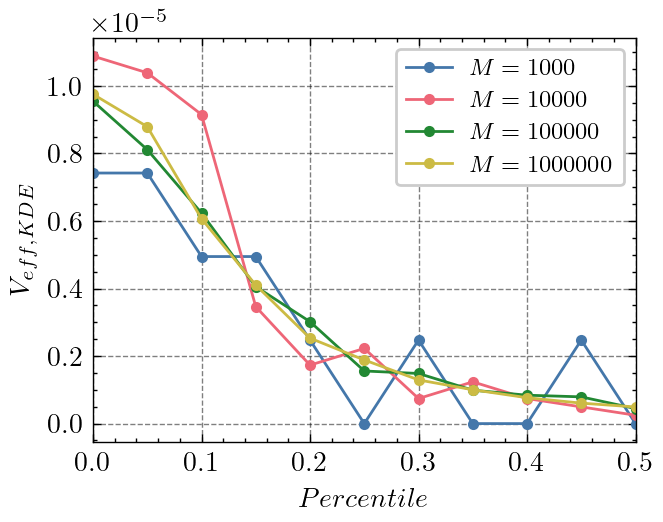

In [193]:
fig, ax = plt.subplots(dpi=200)
# ax.hlines(V_hull, d_vals[0], d_vals[-1], color='black', ls='--', label='$V_{hull}$')
for i, M in enumerate(M_samples):
    ax.plot(d_kde_vals, V_kde_effs[i], '.-', label=f'$M = {int(M)}$')
ax.set_xlim(d_kde_vals[0], d_kde_vals[-1])
ax.set_xlabel("$Percentile$")
ax.set_ylabel("$V_{eff,KDE}$")
# ax.set_ylim(1e-3)
ax.legend(fontsize='small')
# ax.set_yscale('log')

## Total Harmonics Distortion: Max vs Min

In [324]:
dim         = 18
thd_vals    = np.array([total_harmonic_distortion(data_new[i], f0=F0_HZ, dt=DT, N_f=dim) for i in range(N_SAMPLES)])
y_thd       = total_harmonic_distortion(y, f0=F0_HZ, dt=DT, N_f=dim)

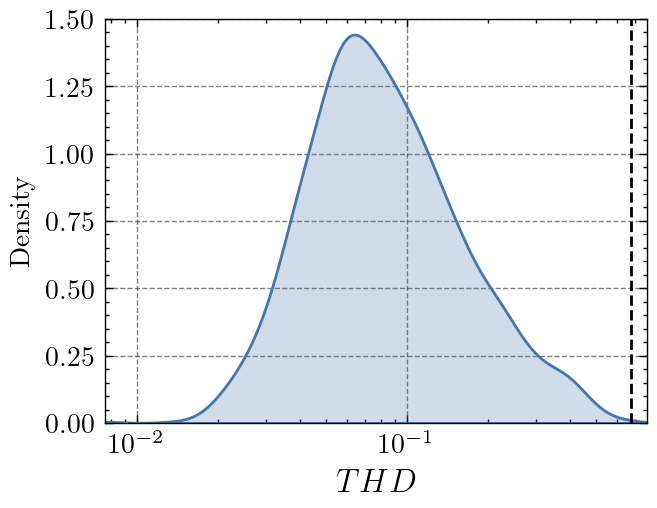

In [325]:
fig, ax = plt.subplots(dpi=200)
ax      = sns.kdeplot(thd_vals, fill=True, log_scale=True)
ax.vlines(y_thd, 0, 1.5, color='black', ls='--')
ax.set_xlim(thd_vals.min(), np.max([thd_vals.max(),y_thd])+0.1)
ax.set_xlabel("$THD$", fontsize='large')
ax.set_ylim(0, 1.5)
fig.savefig("plots/freq_manipulation/svg/thd_dist.svg", transparent=True)
fig.savefig("plots/freq_manipulation/pdf/thd_dist.pdf", transparent=False)
fig.savefig("plots/freq_manipulation/png/thd_dist.png", transparent=False)

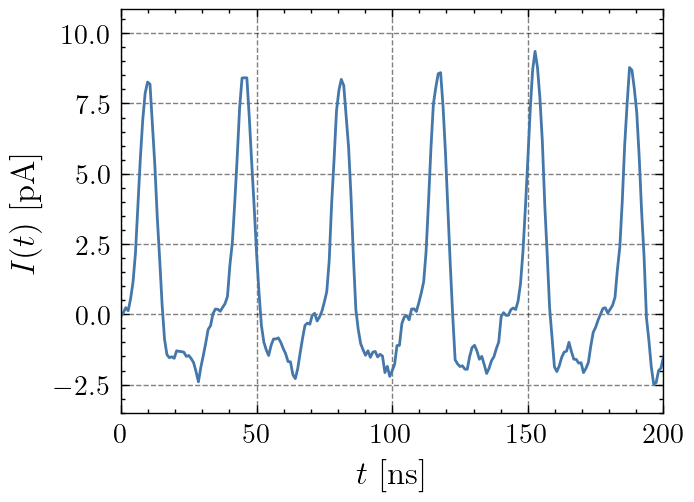

In [326]:
fig, ax = plt.subplots(dpi=200)
ax.plot(t, data_new[np.argmax(thd_vals)])
ax.set_ylabel("$I(t)$ [pA]", fontsize='large')
ax.set_xlabel("$t$ [ns]", fontsize='large')
ax.set_xlim(0,200)
fig.savefig("plots/freq_manipulation/svg/output_at_max_thd.svg", transparent=True)
fig.savefig("plots/freq_manipulation/pdf/output_at_max_thd.pdf", transparent=False)
fig.savefig("plots/freq_manipulation/png/output_at_max_thd.png", transparent=False)

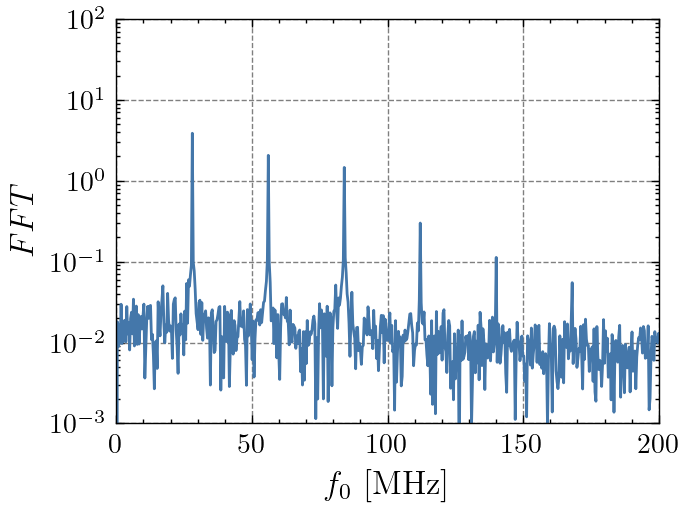

In [327]:
signal   = data_new[np.argmax(thd_vals)].copy()
xf2, yf2 = fft(signal-np.mean(signal), dt=DT)

fig, ax = plt.subplots(dpi=200)
ax.plot(xf2*1e-6, yf2)
ax.set_ylabel("$FFT$", fontsize='large')
ax.set_xlabel("$f_0$ [MHz]", fontsize='large')
ax.set_xlim(0,200)
ax.set_ylim(1e-3,100)
ax.set_yscale('log')
fig.savefig("plots/freq_manipulation/svg/fft_at_max_thd.svg", transparent=True)
fig.savefig("plots/freq_manipulation/pdf/fft_at_max_thd.pdf", transparent=False)
fig.savefig("plots/freq_manipulation/png/fft_at_max_thd.png", transparent=False)

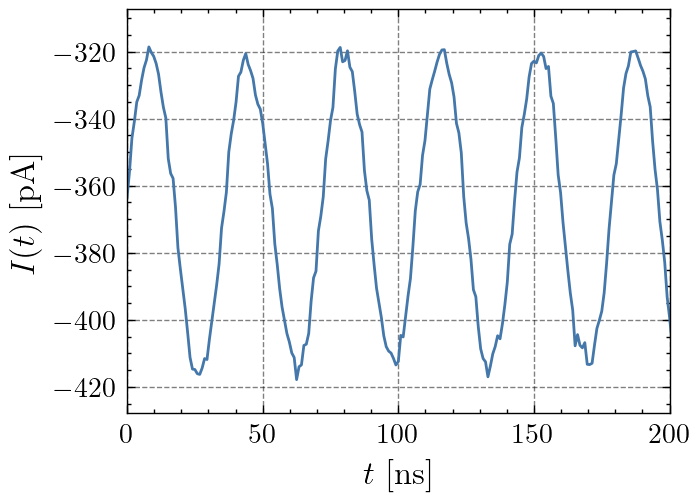

In [328]:
fig, ax = plt.subplots(dpi=200)
ax.plot(t, data_new[np.argmin(thd_vals)])
ax.set_ylabel("$I(t)$ [pA]", fontsize='large')
ax.set_xlabel("$t$ [ns]", fontsize='large')
ax.set_xlim(0,200)
fig.savefig("plots/freq_manipulation/svg/output_at_min_thd.svg", transparent=True)
fig.savefig("plots/freq_manipulation/pdf/output_at_min_thd.pdf", transparent=False)
fig.savefig("plots/freq_manipulation/png/output_at_min_thd.png", transparent=False)

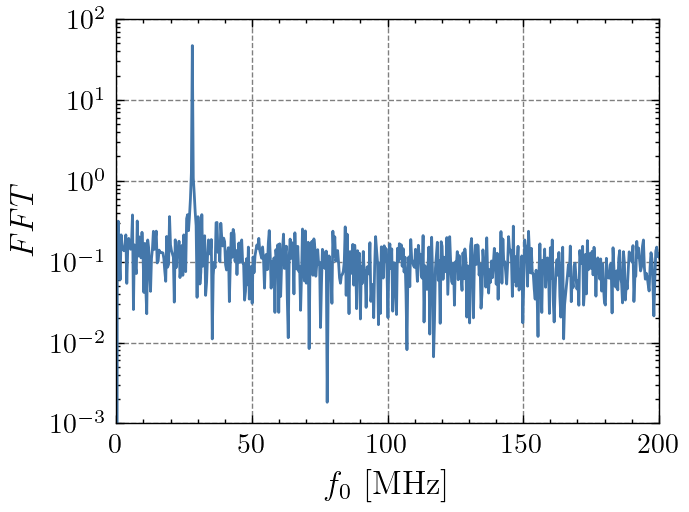

In [329]:
signal   = data_new[np.argmin(thd_vals)].copy()
xf2, yf2 = fft(signal-np.mean(signal), dt=DT)

fig, ax = plt.subplots(dpi=200)
ax.plot(xf2*1e-6, yf2)
ax.set_ylabel("$FFT$", fontsize='large')
ax.set_xlabel("$f_0$ [MHz]", fontsize='large')
ax.set_xlim(0,200)
ax.set_ylim(1e-3,100)
ax.set_yscale('log')
fig.savefig("plots/freq_manipulation/svg/fft_at_min_thd.svg", transparent=True)
fig.savefig("plots/freq_manipulation/pdf/fft_at_min_thd.pdf", transparent=False)
fig.savefig("plots/freq_manipulation/png/fft_at_min_thd.png", transparent=False)

## Asymmetry

In [322]:
dim         = 18
y_hhs       = harmonic_strength(y, f0=F0_HZ, dt=DT, N_f=dim)
num         = np.sqrt(np.sum(y_hhs[::2]**2))
denom       = np.sqrt(np.sum(y_hhs[1::2]**2))
asym_wo     = num / denom

hh_vector   = np.array([harmonic_strength(data_new[i], f0=F0_HZ, dt=DT, N_f=dim) for i in range(N_SAMPLES)])
num         = np.sqrt(np.sum(hh_vector[:,::2]**2,axis=1))
denom       = np.sqrt(np.sum(hh_vector[:,1::2]**2,axis=1))
asym        = num / denom

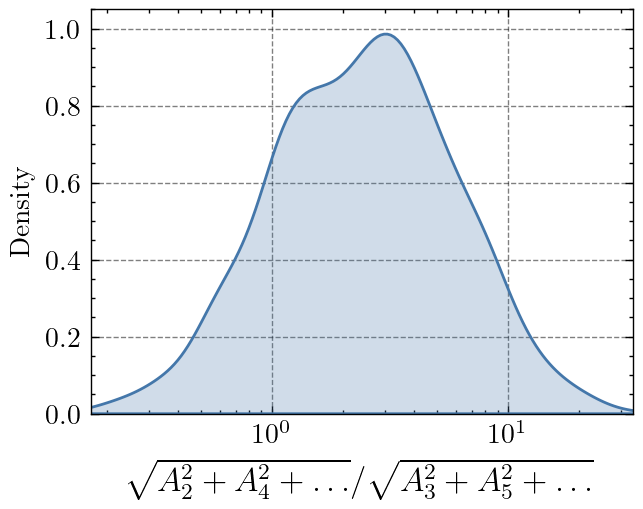

In [323]:
fig, ax = plt.subplots(dpi=200)
ax      = sns.kdeplot(asym, fill=True, log_scale=True)
ax.vlines(asym_wo, 0, 1)
ax.set_xlim(asym.min(), asym.max())
ax.set_xlabel("$\\sqrt{A_2^2 + A_4^2 + \dots} / \\sqrt{A_3^2 + A_5^2 + \dots}$", fontsize='large')
fig.savefig("plots/freq_manipulation/svg/asym_dist.svg", transparent=True)
fig.savefig("plots/freq_manipulation/pdf/asym_dist.pdf", transparent=False)
fig.savefig("plots/freq_manipulation/png/asym_dist.png", transparent=False)

## Center of Mass

In [319]:
dim         = 18
hh_vector   = np.array([harmonic_strength(data_new[i], f0=F0_HZ, dt=DT, N_f=dim) for i in range(N_SAMPLES)])
num         = np.sum(np.arange(2,dim+2)*hh_vector,axis=1)
denom       = np.sum(hh_vector,axis=1)
center_o_m  = num / denom

y_hhs           = harmonic_strength(y, f0=F0_HZ, dt=DT, N_f=dim)
num             = np.sum(np.arange(2,dim+2)*y_hhs)
denom           = np.sum(y_hhs)
center_o_m_wo   = num / denom

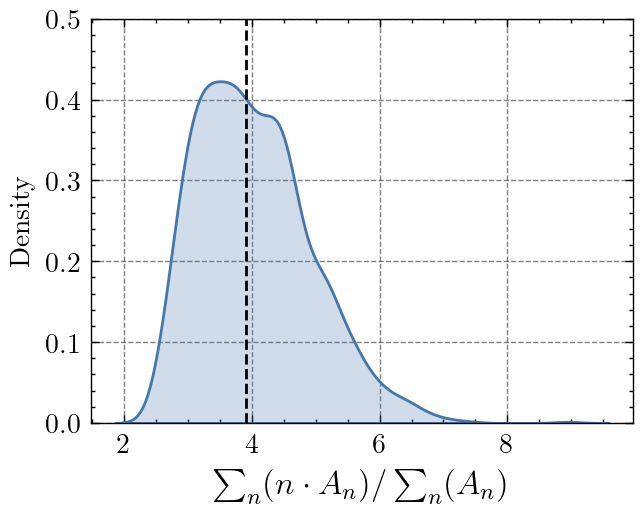

In [321]:
fig, ax = plt.subplots(dpi=200)
ax      = sns.kdeplot(center_o_m, fill=True, log_scale=False)
ax.vlines(center_o_m_wo, 0, 0.5, color='black', ls='--')
ax.set_ylim(0, 0.5)
ax.set_xlabel("$\\sum_n(n \\cdot A_n) / \\sum_n(A_n)$", fontsize='large')
fig.savefig("plots/freq_manipulation/svg/center_of_mass_dist.svg", transparent=True)
fig.savefig("plots/freq_manipulation/pdf/center_of_mass_dist.pdf", transparent=False)
fig.savefig("plots/freq_manipulation/png/center_of_mass_dist.png", transparent=False)